# Breast Cancer Wisconsin – Classificazione
**Pipeline:** dataset → preprocessing → training → valutazione (ROC/AUC, conf. matrix)
Dataset disponibile in `scikit-learn`.

In [5]:
# %pip install scikit-learn matplotlib seaborn

In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

SEED = 42
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

## 1) Confronto modelli con pipeline e CV

In [7]:
models = {
    'LogReg': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=SEED))]),
    'RF': RandomForestClassifier(n_estimators=300, max_depth=None, random_state=SEED),
    'SVM(RBF)': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, kernel='rbf', C=2.0, gamma='scale', random_state=SEED))]),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for name, model in models.items():
    auc = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean()
    print(f'CV AUC – {name}: {auc:.3f}')

fitted = {name: model.fit(X_train, y_train) for name, model in models.items()}

CV AUC – LogReg: 0.996
CV AUC – RF: 0.990
CV AUC – SVM(RBF): 0.996


## 2) ROC multi-modello su test

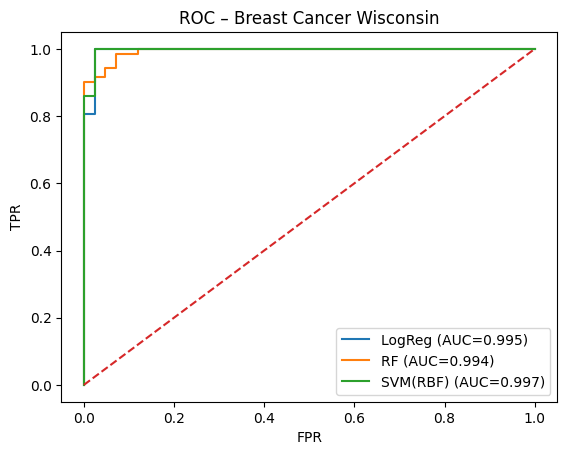

Miglior modello su test: SVM(RBF) (AUC=0.997)
Confusion Matrix:
 [[41  1]
 [ 1 71]]


In [8]:
plt.figure()
for name, model in fitted.items():
    y_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Breast Cancer Wisconsin'); plt.legend(); plt.show()

# Confusion matrix per il migliore (scelgo quello con AUC più alto sul test)
best_name, best_model, best_auc = None, None, -1
for name, model in fitted.items():
    y_prob = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    if auc > best_auc: best_auc, best_name, best_model = auc, name, model

from sklearn.metrics import ConfusionMatrixDisplay
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(f'Miglior modello su test: {best_name} (AUC={best_auc:.3f})')
print('Confusion Matrix:\n', cm)